## Load the FASTA file from the GtRNAdb server

The urllib is used here, but it will be later changed to use keras's resource caching utility.

In [1]:
from keras.utils.data_utils import get_file

fasta_path = get_file('sacCer3-tRNAs.fa', origin='http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/sacCer3-tRNAs.fa')

Using TensorFlow backend.


In [2]:
from Bio.SeqIO.FastaIO import SimpleFastaParser

# generator is iterable
sequence_generator = SimpleFastaParser(open(fasta_path))
    
fasta_sequences = [(seq) for (title, seq) in sequence_generator]

In [3]:
# fasta_sequences holds the original sequences from the file
fasta_sequences[:5]

['GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA',
 'GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA',
 'GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA',
 'GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA',
 'GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA']

For now, the sequences are all upper case to make the neural network more effective at determining sequence.

## Vectorizing the sequences

In [4]:
# these should be later changed to include lower case as well
# chars = ['A', 'C', 'G', 'T']
chars = list(set(''.join(fasta_sequences)))

char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

In [5]:
# how much we tell the rnn before it has to guess
test_length = 25
step = 3

# list of all the tests, semiredundant
test_sequences = []
next_bases = []

# load in training cases
# for seq in sequences:
for seq in fasta_sequences:
    for i in range(0, len(seq) - test_length, step):
        test_sequences.append(seq[i: i + test_length])
        next_bases.append(seq[i + test_length])

In [6]:
import numpy as np

# turn into vectors
# first dimension - each test case
# second dimension - number of hints to give
# third dimension - boolean representation for chars
X = np.zeros((len(test_sequences), test_length, len(chars)), dtype=np.bool)
y = np.zeros((len(next_bases), len(chars)), dtype=np.bool)

for i, seq in enumerate(test_sequences):
    for t, char in enumerate(seq):
        X[i, t, char2index[char]] = 1
    y[i, char2index[next_bases[i]]] = 1

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

print('Build the single LSTM model...')
model = Sequential()
model.add(LSTM(128, input_shape=(test_length, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

Build the single LSTM model...


In [8]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

In [9]:
def splice_introns(rna_sequence):
    spliced_rna_sequence = ''.join([(nt) for (nt) in rna_sequence if nt.isupper()])
    return spliced_rna_sequence

In [10]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

def transcribe(dna_sequence):
    rna_sequence = Seq(dna_sequence, generic_dna).transcribe()
    return rna_sequence

In [11]:
import os
os.makedirs('output', exist_ok=True)

from Barnacle import Barnacle

def create_barnacle(filename, rna_sequence):
    spliced_rna_sequence = splice_introns(rna_sequence)
    rna_model = Barnacle(spliced_rna_sequence)
    rna_model.sample()
    rna_model.save_structure("output/%s" % filename)

In [12]:
import numpy as np;
import seaborn as sns; sns.set()

def heat_map(dna_original, dna_generated):
    length = max(len(dna_original), len(dna_generated))
    # original on first axis
    heatmap = np.zeros((len(dna_original), len(dna_generated)))

    for i in range(length):
        for j in range(length):
            if (dna_original[i] == dna_generated[j]):
                if (i == j):
                    heatmap[i, j] = 1
                else:
                    heatmap[i, j] = 1 / (i - j)**2

    ax = sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
    sns.plt.show()

round 0
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.7950     

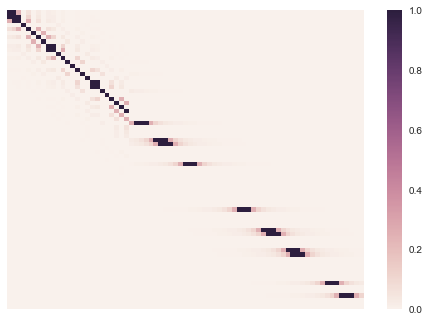

round 1
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.7466     

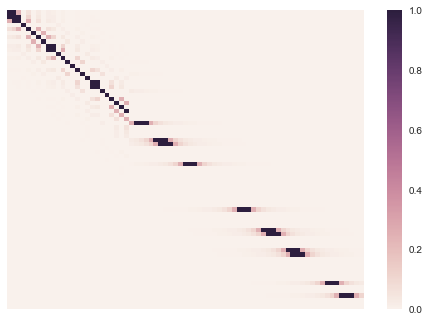

round 2
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.6635     

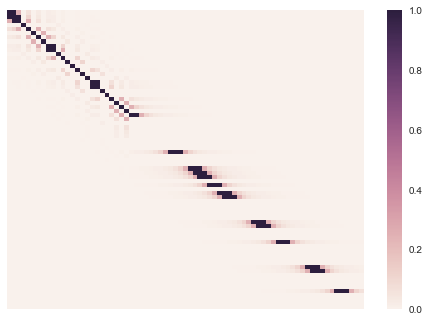

round 3
Epoch 1/1
5109/5109 [==============================] - 5s - loss: 1.5847     

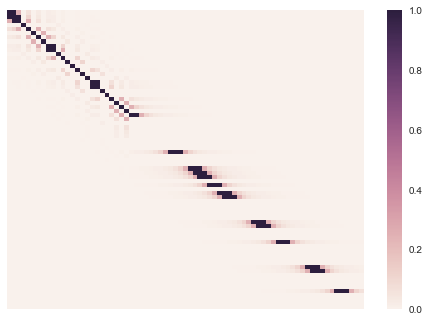

round 4
Epoch 1/1
5109/5109 [==============================] - 5s - loss: 1.5743     

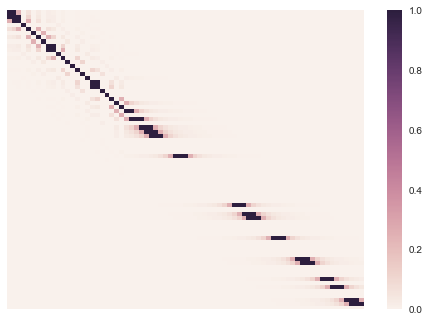

round 5
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.5467     

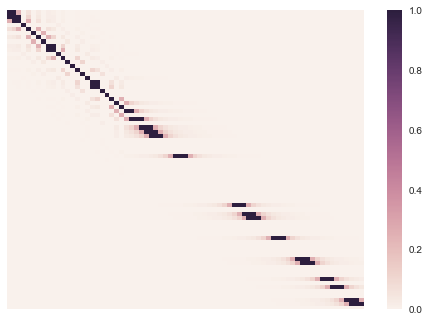

round 6
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.5572     

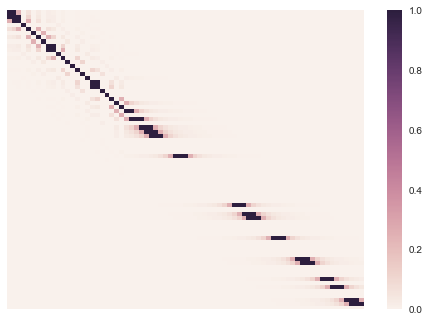

round 7
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.5468     

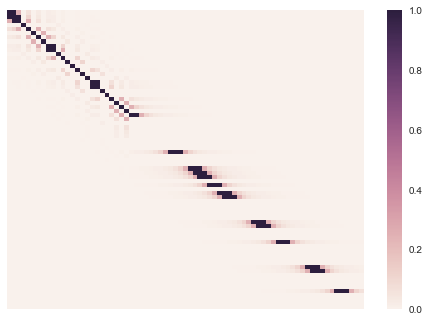

round 8
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.5679     

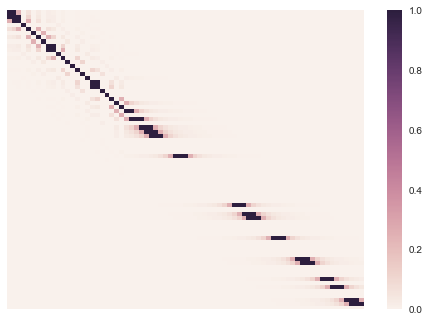

round 9
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.5069     

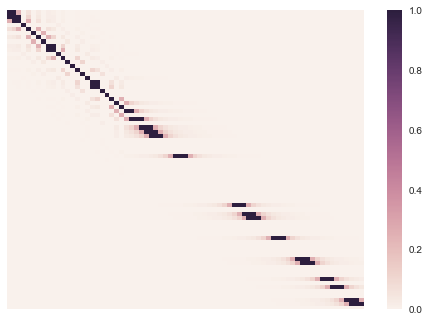

round 10
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 1.4953     

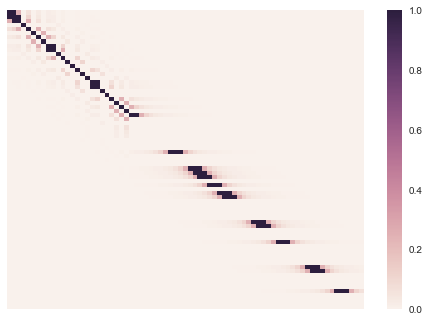

round 11
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.4974     

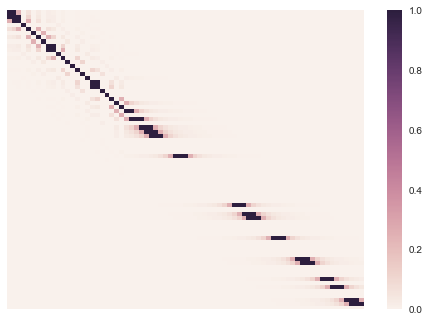

round 12
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.4771     

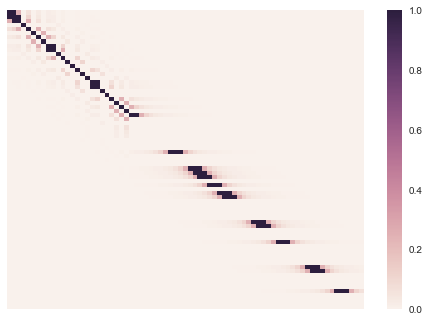

round 13
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 1.4689     

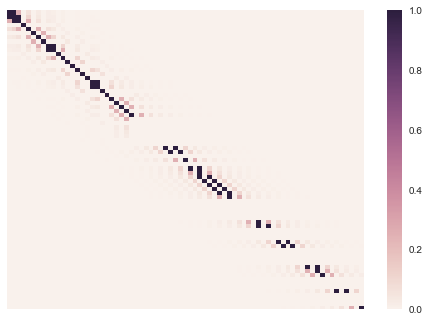

round 14
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.4428     

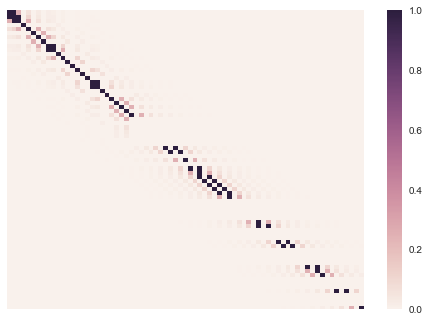

round 15
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.4204     

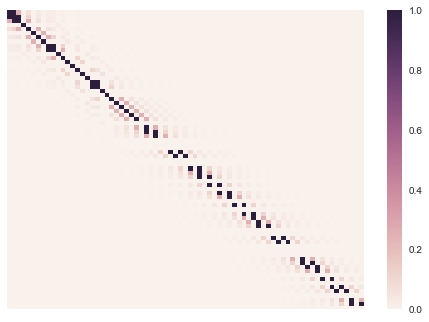

round 16
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 1.3790     

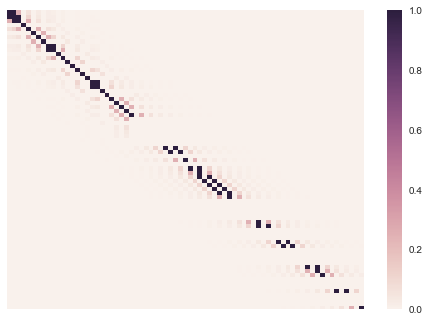

round 17
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.3512     

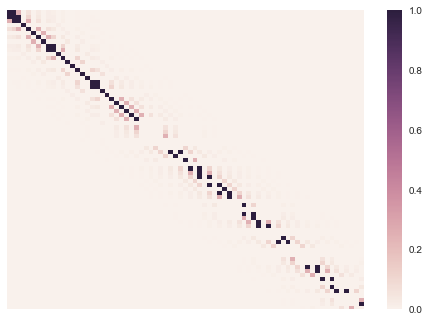

round 18
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 1.4118     

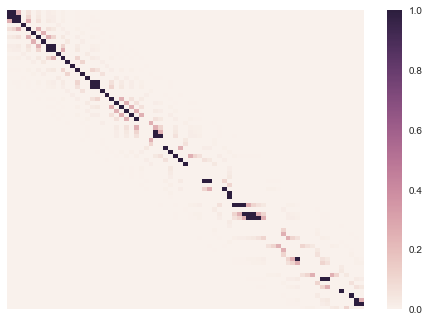

round 19
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 1.3456     

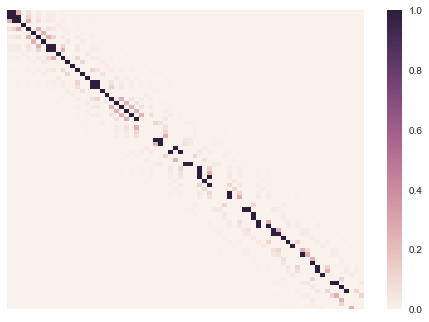

round 20
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.3150      - ETA: 3s - loss: 1.2824

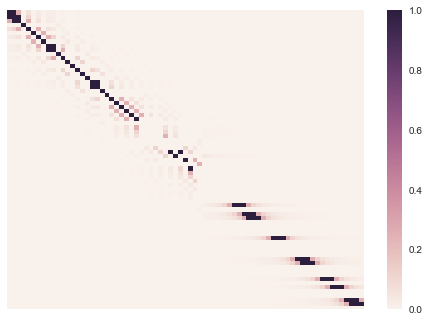

round 21
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 1.2446     

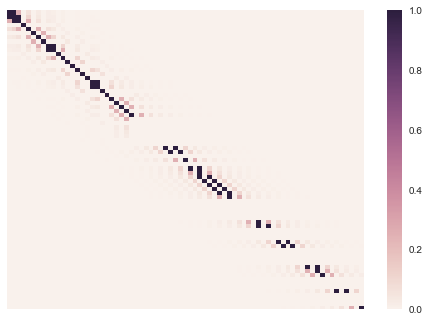

round 22
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 1.1853     

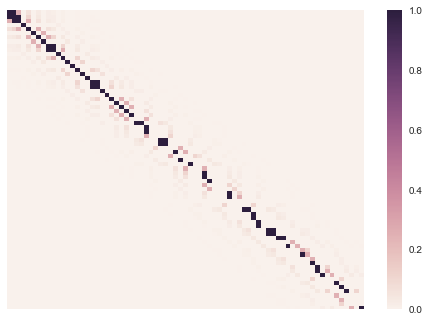

round 23
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 1.0856     

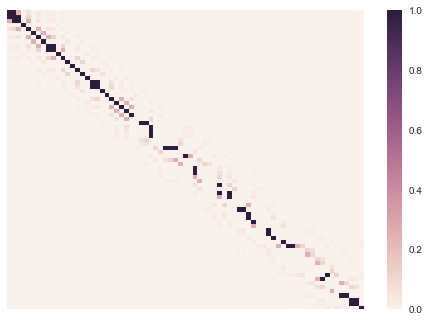

round 24
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 0.9811     

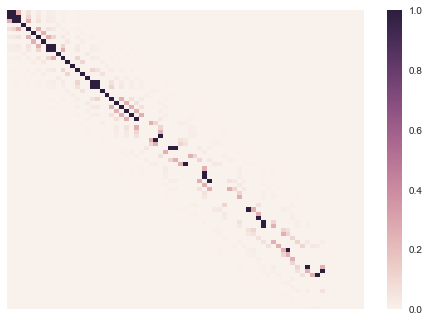

round 25
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.9667     

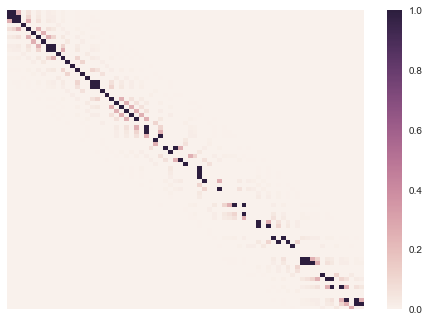

round 26
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 0.7901     

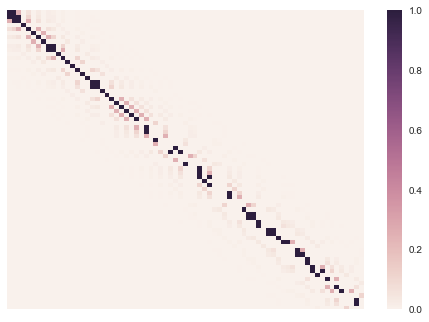

round 27
Epoch 1/1
5109/5109 [==============================] - 4s - loss: 0.6679     

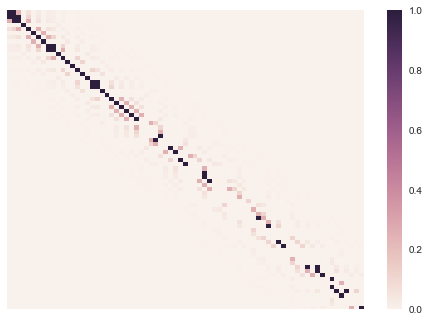

round 28
Epoch 1/1
5109/5109 [==============================] - 5s - loss: 0.5808     

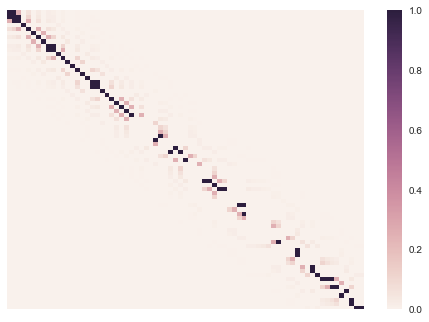

round 29
Epoch 1/1
5109/5109 [==============================] - 10s - loss: 0.9646     

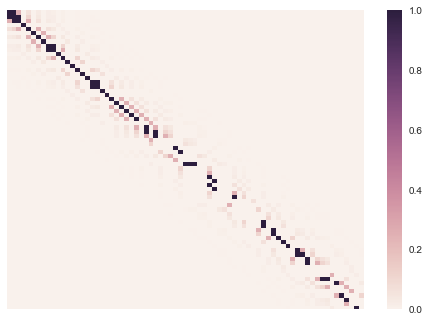

In [15]:
for i in range(30):
    print('round %i' % i)
    model.fit(X, y, batch_size=128, epochs=1)

    pred = model.predict(X[0:1])
    pred_index = np.argmax(pred)
    pred_char = index2char[pred_index]
    print(pred_char, flush=True)

    generated = ''
    sentence = fasta_sequences[0][0: test_length]
    generated += sentence

    print(generated)

    for j in range(73 - test_length):
        x = np.zeros((1, test_length, len(chars)), dtype=np.bool)
        for t, char in enumerate(sentence):
            x[0, t, char2index[char]] = 1
        pred = model.predict(x)
        pred_index = np.argmax(pred)
        pred_char = index2char[pred_index]

        generated += pred_char
        sentence = sentence[1:] + pred_char

    # only testing on the first one
    dna_original = fasta_sequences[0]
    print(dna_original)
    print(generated, flush=True)
    
    rna_sequence = transcribe(generated)
#     create_barnacle("output%i.pdb" % i, rna_sequence)

    heat_map(dna_original, generated)